This notebook shows how to use a general interface in HiGP for regression problems with a PyTorch optimizer.

In this test, we will use the Bike Sharing dataset at "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

We random sample 1000 points for demonstration.

As we hope to make the actual parameters in $(0,\infty)$, we train our parameters in $\mathbb{R}$ and apply the softplus transformation to get the actual parameters.

In [1]:
import higp
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
import requests
import os
%matplotlib inline

Download the dataset.

In [2]:
np_dtype = np.float32

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
zip_filename = os.path.join(os.path.abspath(''), './tmp/Bike-Sharing-Dataset.zip')
day_filename = os.path.join(os.path.abspath(''), './tmp/day.csv')
hour_filename = os.path.join(os.path.abspath(''), './tmp/hour.csv')
readme_filename = os.path.join(os.path.abspath(''), './tmp/Readme.txt')

# Create a temporary folder for the downloaded data if the folder does not exist
tmp_folder = os.path.join(os.path.abspath(''), './tmp')
if not os.path.exists(tmp_folder):
   os.mkdir(tmp_folder)

# Download the zip file
if not os.path.exists(hour_filename):
   response = requests.get(url)
   with open(zip_filename, 'wb') as f:
      f.write(response.content)
   import zipfile
   with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
      zip_ref.extractall(tmp_folder)
   os.remove(zip_filename)
   os.remove(day_filename)
   os.remove(readme_filename)

# Read the CSV file
df = pd.read_csv(hour_filename)
df['dteday'] = (pd.to_datetime(df['dteday'])).dt.dayofyear
df.drop(columns=["instant"], inplace=True)

Scale features to $[-1, 1]$ and normalize labels

In [3]:
data_array = df.values
all_x = data_array[:, :-1]
all_y = data_array[:, -1]

# Scale features and normalize labels
all_x_max = np.max(all_x, 0)
all_x_min = np.min(all_x, 0)
all_x = 2.0 * (all_x - all_x_min[np.newaxis, :]) / (all_x_max[np.newaxis, :] - all_x_min[np.newaxis, :]) - 1.0
all_y = (all_y - np.mean(all_y)) / np.std(all_y)

# Random 80/20 split of the data
n_all = all_x.shape[0]
n_sample = 1000
n_train = int(math.floor(0.8 * n_sample))
n_test = n_sample - n_train
np.random.seed(42)
sample_array = np.random.choice(n_all, n_sample, replace=False)

train_x = np.ascontiguousarray(all_x[sample_array[:n_train], :].T).astype(np_dtype)
train_y = np.ascontiguousarray(all_y[sample_array[:n_train]]).astype(np_dtype)
test_x = np.ascontiguousarray(all_x[sample_array[n_train:], :].T).astype(np_dtype)
test_y = np.ascontiguousarray(all_y[sample_array[n_train:]]).astype(np_dtype)

Remember to use the `ascontiguousarray()` method in NumPy to guarantee that `train_x, train_y, test_x, test_y` are stored contiguously.

Now let's check the shapes of these four arrays. We can see that each data point is stored in one column in `train_x` and `test_x`.

In [4]:
print("Shape of train_x : ", train_x.shape)
print("Shape of train_y : ", train_y.shape)
print("Shape of test_x : ", test_x.shape)
print("Shape of test_y : ", test_y.shape)

Shape of train_x :  (15, 800)
Shape of train_y :  (800,)
Shape of test_x :  (15, 200)
Shape of test_y :  (200,)


Create a GP regression model and a PyTorch Adam optimizer. 

We use the RBF (Gaussian) kernel here by using `higp.GaussianKernel`.

In [5]:
torch_dtype = torch.float32 if np_dtype == np.float32 else torch.float64
gprproblem = higp.gprproblem.setup(data=train_x, label=train_y, kernel_type=higp.GaussianKernel)
model = higp.GPRModel(gprproblem, dtype=torch_dtype)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Run 50 steps of Adam.

In [6]:
loss_history, param_histpry = higp.gpr_torch_minimize(model, optimizer, maxits=50, print_info=True)

Iteration (max 50), Elapsed time (sec), Loss, Hyperparameters (l, s, f, before nnt)
1, 0.05, 1.11859, 0.100, -0.100, -0.100
2, 0.06, 1.07075, 0.200, -0.200, -0.176
3, 0.07, 1.02448, 0.300, -0.300, -0.197
4, 0.08, 0.97753, 0.400, -0.401, -0.177
5, 0.09, 0.92895, 0.500, -0.502, -0.139
6, 0.09, 0.87937, 0.599, -0.603, -0.095
7, 0.11, 0.82940, 0.699, -0.704, -0.055
8, 0.12, 0.77920, 0.798, -0.806, -0.028
9, 0.13, 0.72863, 0.897, -0.909, -0.017
10, 0.15, 0.67757, 0.995, -1.012, -0.019
11, 0.17, 0.62618, 1.092, -1.115, -0.031
12, 0.17, 0.57475, 1.189, -1.219, -0.045
13, 0.18, 0.52354, 1.284, -1.323, -0.056
14, 0.20, 0.47263, 1.378, -1.428, -0.059
15, 0.22, 0.42197, 1.471, -1.534, -0.052
16, 0.23, 0.37143, 1.562, -1.639, -0.034
17, 0.24, 0.32093, 1.651, -1.746, -0.006
18, 0.25, 0.27045, 1.738, -1.853, 0.028
19, 0.27, 0.22004, 1.824, -1.960, 0.066
20, 0.29, 0.16973, 1.908, -2.067, 0.103
21, 0.29, 0.11951, 1.990, -2.175, 0.138
22, 0.30, 0.06945, 2.071, -2.284, 0.167
23, 0.31, 0.01925, 2.150, -2

Run predictions with the initial parameters and the trained parameters.

In [7]:
Pred0 = higp.gpr_prediction(data_train=train_x,
                            label_train=train_y,
                            data_prediction=test_x,
                            kernel_type=higp.GaussianKernel,
                            pyparams=np.hstack((0.0, 0.0, 0.0)))

Pred = higp.gpr_prediction(data_train=train_x,
                           label_train=train_y,
                           data_prediction=test_x,
                           kernel_type=higp.GaussianKernel,
                           pyparams=model.get_params())

Now let's check the root mean squared errir (RMSE) of the predition.

In [8]:
rmse0 = np.linalg.norm(Pred0.prediction_mean - test_y) / np.sqrt(float(n_test))
rmse = np.linalg.norm(Pred.prediction_mean - test_y) / np.sqrt(float(n_test))
print("RMSE (before training): %g, RMSE (after training): %g\n" % (rmse0, rmse))

RMSE (before training): 0.400024, RMSE (after training): 0.0186565



Since $X$ is high dimensional, we sort the index by prediction value. This provides a better visualization of the 95% Confidence interval.

Note that the two subplots have different orders.

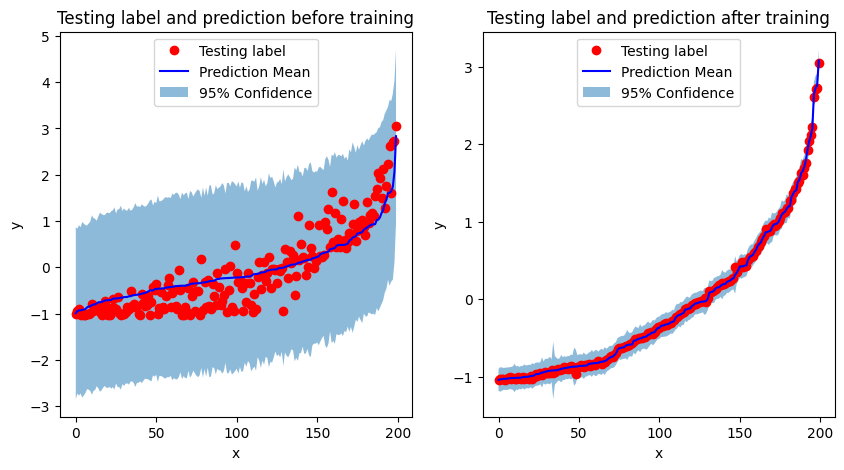

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pred0_mean = Pred0.prediction_mean
pred0_stddev = Pred0.prediction_stddev
pred_mean = Pred.prediction_mean
pred_stddev = Pred.prediction_stddev

idx = np.argsort(pred0_mean)
idx0 = np.argsort(pred_mean)
axs[0].plot(test_y[idx], 'ro')
axs[0].plot(pred0_mean[idx], 'b-')
axs[0].fill_between(range(len(pred0_mean)), pred0_mean[idx] - 1.96 * pred0_stddev[idx], pred0_mean[idx] + 1.96 * pred0_stddev[idx], alpha=0.5)
axs[0].set_title('Testing label and prediction before training')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
axs[1].plot(test_y[idx0], 'ro')
axs[1].plot(pred_mean[idx0], 'b-')
axs[1].fill_between(range(len(pred_mean)), pred_mean[idx0] - 1.96 * pred_stddev[idx0], pred_mean[idx0] + 1.96 * pred_stddev[idx0], alpha=0.5)
axs[1].set_title('Testing label and prediction after training')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend(['Testing label', 'Prediction Mean', '95% Confidence'], loc='upper center')
plt.show()
plt.close(fig)